#Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/Users/xixuan/opt/anaconda3/envs/criticalMedia/bin/python


# Install dependencies:

In [10]:
install_packages = False
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /Users/xixuan/opt/anaconda3/envs/criticalmedia

  added / updated specs:
    - tensorflow-hub


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1h             |       haf1e3a3_0         1.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.9 MB

The following packages will be UPDATED:

  ca-certificates    anaconda::ca-certificates-2020.10.14-0 --> conda-forge::ca-certificates-2020.11.8-h033912b_0
  certifi                anaconda::certifi-2020.6.20-py37_0 --> conda-forge::certifi-2020.11.8-py37hf985489_0

The following packages will be SUPERSEDED by a higher-priority channel

# Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [3]:
data_path = './data/videoinfo_pwvVephTIHU_2020_11_29-19_23_17_comments.tab'
output_path = "./output/"

new_embeddings = False

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [4]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Creation of the directory ./output/ failed


# Load Data
Load you data as a pandas dataframe

In [17]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [18]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [19]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

/Users/xixuan/opt/anaconda3/envs/criticalMedia/lib/python3.7/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 4022/4022 [00:01<00:00, 3120.88it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [5]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-11-26 00:17:10,Cipesco Pician,But but but...Greta said something else 😄,0,But but but...Greta said something else 😄\n\n
1,2020-11-18 13:57:27,Michael Krick,Every generation from the first caveman who saw a bolt of lightning and filled his animal skin to this generation think&#39;s the world is coming to an end. The world comes to an end for thousands of people every day. Someday you will be one of them. Enjoy life while you can and stop worrying about climate change.,0,Every generation from the first caveman who saw a bolt of lightning and filled\nhis animal skin to this generation think's the world is coming to an end. The\nworld comes to an end for thousands of people every day. Someday you will be\none of them. Enjoy life while you can and stop worrying about climate change.\n\n
2,2020-11-04 22:45:26,JeffJests,"If the celestial dice rolled in my favor, Hurricane Sandy would move a bit faster up the coast and at midnight, Hurricane Sandy would arrive at Boston. This way, 20 feet of water would surge into the city, hopefully convincing him that it&#39;s a very real concern. That way, Lower Manhattan would be spared and a bigger city would be saved.",0,"If the celestial dice rolled in my favor, Hurricane Sandy would move a bit\nfaster up the coast and at midnight, Hurricane Sandy would arrive at Boston.\nThis way, 20 feet of water would surge into the city, hopefully convincing him\nthat it's a very real concern. That way, Lower Manhattan would be spared and a\nbigger city would be saved.\n\n"
3,2020-11-01 04:12:53,Saul Contreras,I think this guy is getting paid by oil companies.,0,I think this guy is getting paid by oil companies.\n\n
4,2020-10-31 16:10:52,Lady Tate,remember to include the scientific FACT of the SUN and INFLUENCES of MAGNETISM BEING INTERPLANETARY in NATURE having MUCH MORE to do w/ OUR ATMOSPHERIC and TERRESTRIAL STATES/CONDITIONS THAN WHAT HUMAN SOCIETY HAS DONE (OR NOT)! PEOPLE NEED TO GAIN MORE KNOWLEDGE BEFORE SPEAKING/THINKING. without good comprehension one becomes confused and LED BY THOSE INTERESTS that have NO WISH to SECURE ANYONE/ANYTHING beyond their OWN self-interest ($$$)! we have PROBLEMS (real ones) in that instance (TO BE SURE)! but there needs to be REAL ATTENTION GIVEN to OUR RESOURCES and that means OUR NATURAL WORLD! OUR EARTH IS AN ECO-SYSTEM OF THE GREATEST POWER AS WELL AS OF THE HIGHEST DELICACY!,0,remember to include the scientific FACT of the SUN and INFLUENCES of MAGNETISM\nBEING INTERPLANETARY in NATURE having MUCH MORE to do w/ OUR ATMOSPHERIC and\nTERRESTRIAL STATES/CONDITIONS THAN WHAT HUMAN SOCIETY HAS DONE (OR NOT)!\nPEOPLE NEED TO GAIN MORE KNOWLEDGE BEFORE SPEAKING/THINKING. without good\ncomprehension one becomes confused and LED BY THOSE INTERESTS that have NO\nWISH to SECURE ANYONE/ANYTHING beyond their OWN self-interest ($$$)! we have\nPROBLEMS (real ones) in that instance (TO BE SURE)! but there needs to be REAL\nATTENTION GIVEN to OUR RESOURCES and that means OUR NATURAL WORLD! OUR EARTH\nIS AN ECO-SYSTEM OF THE GREATEST POWER AS WELL AS OF THE HIGHEST DELICACY!\n\n


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [6]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

## Embed Documents
Produce embeddings of your documents.

In [7]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

(4022, 512)

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.         -0.01715221 -0.04034043 ...  0.02671194  0.0686752
   0.06104154]
 [-0.01715221  1.          0.2281855  ...  0.36380428  0.26033556
   0.13954692]
 [-0.04034043  0.2281855   1.         ...  0.12289812  0.13378306
   0.04235145]
 ...
 [ 0.02671194  0.36380428  0.12289812 ...  0.99999994  0.4810893
   0.0890125 ]
 [ 0.0686752   0.26033556  0.13378306 ...  0.4810893   0.9999999
   0.11477676]
 [ 0.06104154  0.13954692  0.04235145 ...  0.0890125   0.11477676
   1.        ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

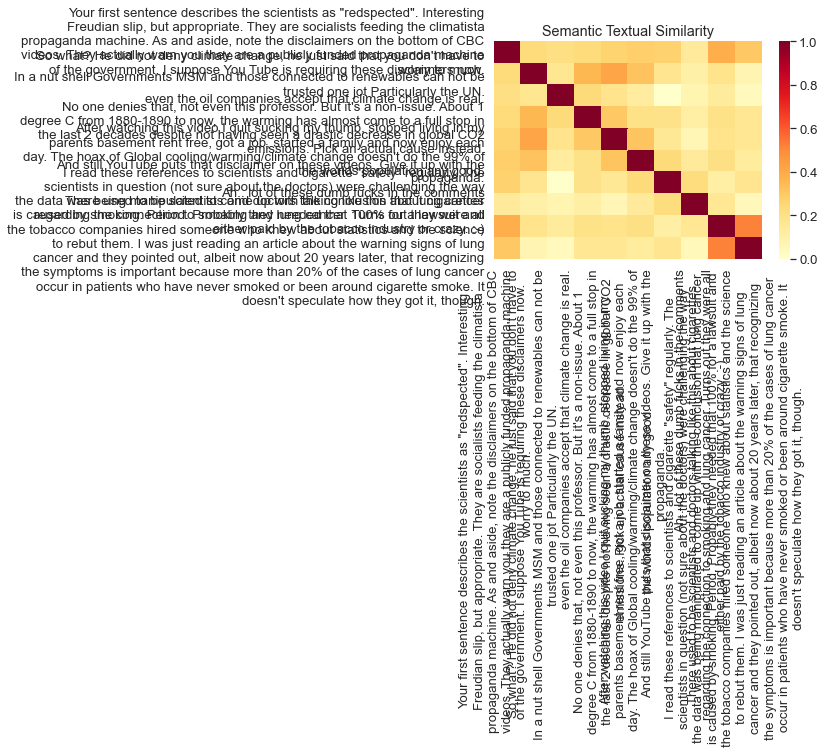

In [12]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 10
off_set = 400

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [14]:
comment_index = 100
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

so someone from MIT says climate change isn't a problem but doesn't offer any
evidence




Print similar comments.

In [15]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: so someone from MIT says climate change isn't a problem but doesn't offer any
evidence


Top similar comment 2: @ to clarify - i think this MIT guy is an idiot. I think people who
can't comprehend anthropogenic climate change as factual are misguided. We are
on the same page


Top similar comment 3: Since when has Lindzen been a responsible scientist?

scientists-take-on-richard-lindzen

lindzen/ MIT has also told him he is wrong. OK? "See also the United States
Historical Climatology Network for actual measurements that totally debunk the
deceit of man made climate change." No they don't


Top similar comment 4: So what? He did not deny climate change, he just said that you don't have to
worry to much.


Top similar comment 5: I've always wanted to be able to call an MIT scientist a barking idiot and be
perfectly justified. What an obtuse, self-important, lazy minded jackass. All
scientists work for the government? Gee whiz, what an Einstein! I wonder if he
thou